In [3]:
import os
import sys
from collections import defaultdict
from functools import reduce, partial

import numpy as np
import pandas as pd
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import ete3
from ete3 import PhyloTree
from Bio import SeqIO

4.387344727816064


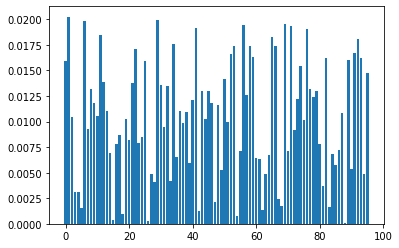

In [46]:
a = np.random.random(96)
a = a / a.sum()
print(scipy.stats.entropy(a))
plt.bar(np.arange(96), a);

4.564348191467836


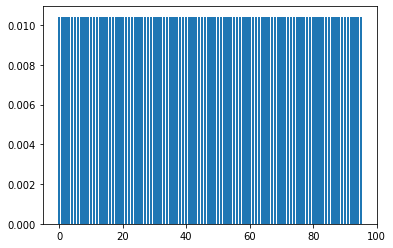

In [47]:
b = np.ones(96)
b = b / b.sum()
print(scipy.stats.entropy(b))
plt.bar(np.arange(96), b);

3.523707089188763


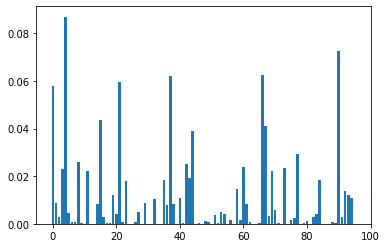

In [48]:
c = np.random.chisquare(.5, 96)
c = c / c.sum()
print(scipy.stats.entropy(c))
plt.bar(np.arange(96), c);

3.828900502490261


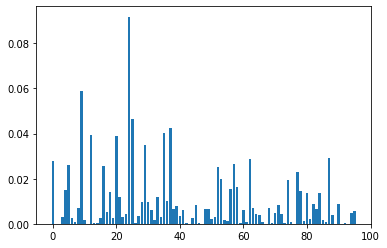

In [49]:
d = np.random.gamma(.5, 10, 96)
d = d / d.sum()
print(scipy.stats.entropy(d))
plt.bar(np.arange(96), d);

2.537365977619637


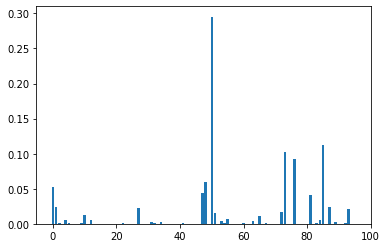

In [52]:
d = np.random.gamma(.1, 100, 96)
d = d / d.sum()
print(scipy.stats.entropy(d))
plt.bar(np.arange(96), d);